In [1]:
import geopandas as gpd

gdf = gpd.read_file('data/San Francisco/pm_trav.shp')
gdf.columns

Index(['temp_f', 'rh', 'hi_f', 'geometry'], dtype='object')

In [2]:
gdf = gdf.to_crs(epsg=3857)
gdf.total_bounds

array([-13638164.9255897 ,   4538204.49914898, -13621656.61617002,
         4555442.96953534])

In [82]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

In [83]:
coordinates = gdf[['x', 'y']].to_numpy()
print(coordinates)

[[-13636427.4138709    4544374.69894476]
 [-13636439.28794991   4544373.2910385 ]
 [-13636471.57060225   4544370.70987753]
 ...
 [-13633623.83249527   4551429.76041452]
 [-13633621.97717042   4551418.01991558]
 [-13633620.30737806   4551405.57500116]]


In [84]:
len(coordinates)

20724

## No need to rasterize!

In [62]:
import rasterio as rio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
# Define the raster grid resolution and extent
resolution = 10  # Cell size in projection units (e.g., meters)
xmin, ymin, xmax, ymax = gdf.total_bounds  # Extent of the shapefile
width = int((xmax - xmin) / resolution)  # Number of columns
height = int((ymax - ymin) / resolution)  # Number of rows
transform = from_bounds(xmin, ymin, xmax, ymax, width, height)

# Prepare geometries and temperature values for rasterization
shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf['temp_f']))

# Rasterize the shapefile
raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Fill value for empty cells
    dtype="float32"  # Data type of the raster
)

# Save the rasterized data to a GeoTIFF file
output_tiff_path = "./temperature_raster.tif"
with rio.open(
    output_tiff_path,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,  # Single band
    dtype="float32",
    crs=gdf.crs,  # Use the CRS from the shapefile
    transform=transform,
) as dst:
    dst.write(raster, 1)  # Write the raster data to band 1

print(f"Raster saved to {output_tiff_path}")

Raster saved to ./temperature_raster.tif


In [63]:
tif = "temperature_raster.tif"
with rio.open(tif) as src:
    temp = src.read(1)
    bounds = src.bounds
    crs = src.crs

In [64]:
temp = temp.to_crs(epsg=3758)

AttributeError: 'numpy.ndarray' object has no attribute 'to_crs'

In [65]:
import matplotlib.pyplot as plt

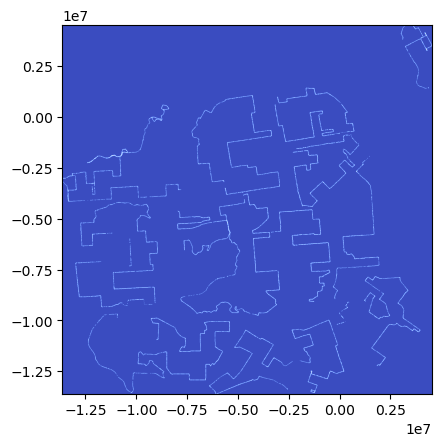

In [66]:
plt.imshow(temp, cmap='coolwarm', extent=bounds)

In [67]:
from src.utils import (
    load_dataset,
    # rasterize_temp
)
import Datasets

In [68]:
city = 'San Francisco'
data_dir = f'data/{city}'

In [69]:
data = load_dataset(data_dir, city)

In [70]:
idx = len(data.coords)
idx

8189

In [71]:
y = []

for i in range(idx):
    temp = data[i]
    y.append(temp)

len(y)

8189

In [85]:
import torch
import numpy as np

# X, y = np.array(data.coords), np.array(y)
X, y = coordinates, gdf.temp_f

In [86]:
X.shape, y.shape

((20724, 2), (20724,))

In [87]:
# Now, we need to standardize the data for the final fit
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

In [89]:
y_train

0        3.128344
1        3.128344
2        2.548778
3        2.548778
4        2.741966
           ...   
20719   -1.315000
20720   -1.250604
20721   -1.250604
20722   -1.250604
20723   -1.250604
Name: temp_f, Length: 20724, dtype: float64

# Using GPyTorch

In [90]:
import math
import torch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Convert the arrays to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [92]:
x_train.shape, y_train.shape

(torch.Size([20724, 2]), torch.Size([20724]))

In [94]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

fixed_noise = torch.full_like(y_train, 0.04)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=fixed_noise)
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [95]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.031   lengthscale: 0.693
Iter 2/50 - Loss: 0.912   lengthscale: 0.644
Iter 3/50 - Loss: 0.802   lengthscale: 0.598
Iter 4/50 - Loss: 0.701   lengthscale: 0.555
Iter 5/50 - Loss: 0.607   lengthscale: 0.514
Iter 6/50 - Loss: 0.521   lengthscale: 0.475
Iter 7/50 - Loss: 0.436   lengthscale: 0.440
Iter 8/50 - Loss: 0.356   lengthscale: 0.406
Iter 9/50 - Loss: 0.271   lengthscale: 0.375
Iter 10/50 - Loss: 0.179   lengthscale: 0.345
Iter 11/50 - Loss: 0.071   lengthscale: 0.317
Iter 12/50 - Loss: -0.046   lengthscale: 0.291
Iter 13/50 - Loss: -0.160   lengthscale: 0.267
Iter 14/50 - Loss: -0.258   lengthscale: 0.244
Iter 15/50 - Loss: -0.319   lengthscale: 0.222
Iter 16/50 - Loss: -0.391   lengthscale: 0.203
Iter 17/50 - Loss: -0.447   lengthscale: 0.185
Iter 18/50 - Loss: -0.504   lengthscale: 0.169
Iter 19/50 - Loss: -0.505   lengthscale: 0.155
Iter 20/50 - Loss: -0.514   lengthscale: 0.143
Iter 21/50 - Loss: -0.484   lengthscale: 0.132
Iter 22/50 - Loss: -0.473   lengt